## Objetivo general
Este cuaderno tiene como propósito realizar un Análisis Exploratorio de Datos (EDA) a partir de una API, con el fin de comprender la estructura, calidad y comportamiento de los datos, identificando patrones, valores atípicos y relaciones relevantes.

### Importación de librerías
Importamos las librerías necesarias para análisis de datos, visualización y herramientas interactivas.


In [ ]:
import os
import glob
import pandas as pd
import ast
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import geopandas as gpd
import ast

## Procesamiento y combinación de datos
Procesar múltiples archivos CSV generados desde una API (OpenStreetMap), combinarlos en un solo DataFrame, generar un resumen de contenidos por ciudad y categoría, y guardar los resultados en archivos CSV.

In [ ]:

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

# Carpeta de entrada y salida
input_folder = r"C:\Users\ASUS\Desktop\proyecto03\dags\data"
output_file = os.path.join(input_folder, "combined_osm_data.csv")
summary_file = os.path.join(input_folder, "summary_osm_data.csv")  # ← archivo resumen

# Buscar todos los archivos CSV que terminan en "_osm_info.csv"
files = glob.glob(os.path.join(input_folder, "*_osm_info.csv"))

# Funciones de clasificación
def map_traffic_signal(val):
    values = {"traffic_lights", "signal", "pedestrian_crossing", "ramp_meter", "level_crossing", "emergency", "bridge"}
    return val.lower().strip() if str(val).lower().strip() in values else "unknown"

def map_crossing(val):
    values = {"uncontrolled", "marked", "unmarked", "zebra", "pelican", "puffin", "toucan"}
    v = val.lower().strip()
    return "combinations" if ";" in v else (v if v in values else "unknown")

# Inicializar listas para datos crudos y resumen
raw_data = []
summary = []

# Columnas requeridas
required_cols = ['id', 'category', 'latitude', 'longitude', 'tags']

# Procesar cada archivo
for file in files:
    city = os.path.basename(file).replace("_osm_info.csv", "")
    try:
        df = pd.read_csv(file)
        available_cols = df.columns.tolist()
        missing_cols = [col for col in required_cols if col.lower() not in [c.lower() for c in available_cols]]
        if missing_cols:
            continue

        tags_col = next((col for col in available_cols if col.lower() == 'tags'), None)
        if not tags_col:
            continue

        df['city'] = city
        df['parsed_tags'] = df[tags_col].apply(
            lambda x: ast.literal_eval(x) if isinstance(x, str) and x.strip() else {}
        )

        tags_expanded = df['parsed_tags'].apply(pd.Series)
        df_expanded = pd.concat([df.drop(columns=['parsed_tags']), tags_expanded], axis=1)
        df_expanded.fillna("unknown", inplace=True)

        df = df[df["category"].isin(["school", "hospital", "traffic_signals", "crossing"])]
        df_expanded = df_expanded[df_expanded["category"].isin(["school", "hospital", "traffic_signals", "crossing"])]

        cols_to_keep = ['id', 'category', 'latitude', 'longitude', tags_col, 'city']
        cols_to_keep = [col for col in cols_to_keep if col in df.columns]

        if not df.empty:
            raw_data.append(df[cols_to_keep])

        city_summary = []

        for cat in ["school", "hospital"]:
            count = df_expanded[df_expanded["category"] == cat].shape[0]
            if count > 0:
                city_summary.append({"city": city, "group": "category", "value": cat, "count": count})

        ts_df = df_expanded[df_expanded["category"] == "traffic_signals"]
        if not ts_df.empty and "traffic_signals" in df_expanded.columns:
            ts_df["mapped_ts"] = ts_df["traffic_signals"].apply(map_traffic_signal)
            for val, cnt in ts_df["mapped_ts"].value_counts().items():
                city_summary.append({"city": city, "group": "traffic_signals", "value": val, "count": cnt})

        cross_df = df_expanded[df_expanded["category"] == "crossing"]
        if not cross_df.empty and "crossing" in df_expanded.columns:
            cross_df["mapped_cross"] = cross_df["crossing"].apply(map_crossing)
            for val, cnt in cross_df["mapped_cross"].value_counts().items():
                city_summary.append({"city": city, "group": "crossing", "value": val, "count": cnt})

        if city_summary:
            summary.extend(city_summary)

    except Exception as e:
        print(f"Error procesando {file}: {e}")
        continue

# Crear DataFrame combinado
df_raw = pd.concat(raw_data, ignore_index=True) if raw_data else pd.DataFrame()
for col in df_raw.columns:
    if col.lower() == 'tags' and col != 'tags':
        df_raw.rename(columns={col: 'tags'}, inplace=True)

# Crear DataFrame resumen
df_summary = pd.DataFrame(summary)

# Guardar resumen como CSV adicional
if not df_summary.empty:
    df_summary.to_csv(summary_file, index=False)
    print(f"Resumen guardado en: {summary_file}")

# Convertir a tabla pivot
if not df_summary.empty:
    try:
        pivot = df_summary.pivot_table(index="city", columns=["group", "value"], values="count", fill_value=0)
        pivot.columns = [f"{grp}_{val}" for grp, val in pivot.columns]
        pivot.reset_index(inplace=True)
    except:
        pivot = pd.DataFrame()
else:
    pivot = pd.DataFrame()

# Eliminar columnas específicas
columns_to_drop = [
    'category_hospital', 'category_school', 'crossing_combinations', 'crossing_marked',
    'crossing_unmarked', 'crossing_uncontrolled', 'crossing_unknown', 'crossing_zebra',
    'traffic_signals_bridge', 'traffic_signals_emergency', 'traffic_signals_level_crossing',
    'traffic_signals_pedestrian_crossing', 'traffic_signals_ramp_meter', 'traffic_signals_signal',
    'traffic_signals_traffic_lights', 'traffic_signals_unknown'
]

if not df_raw.empty:
    df_raw.drop(columns=[col for col in columns_to_drop if col in df_raw.columns], inplace=True, errors='ignore')

if not pivot.empty:
    pivot.drop(columns=[col for col in columns_to_drop if col in pivot.columns], inplace=True, errors='ignore')

# Eliminar columna section si existe
df_raw.drop(columns=['section'], inplace=True, errors='ignore')
pivot.drop(columns=['section'], inplace=True, errors='ignore')

# Rellenar NaNs
df_raw.fillna("unknown", inplace=True)
pivot.fillna("unknown", inplace=True)

# Combinar y guardar
combined_data = []
if not df_raw.empty:
    combined_data.append(df_raw)
if not pivot.empty:
    combined_data.append(pivot)

if combined_data:
    df_combined = pd.concat(combined_data, ignore_index=True, sort=False)
    df_combined.to_csv(output_file, index=False)
    print(f"Archivo combinado guardado en: {output_file}")
else:
    print("No se generaron datos combinados.")


Resumen guardado en: C:\Users\Acer\OneDrive\Escritorio\apis_proyecto\datos\summary_osm_data.csv
Archivo combinado guardado en: C:\Users\Acer\OneDrive\Escritorio\apis_proyecto\datos\combined_osm_data.csv


### Carga del conjunto de datos combinado
Este paso permite verificar la estructura y el contenido del conjunto de datos combinado, asegurando que los datos se hayan procesado correctamente en la celda anterior.


In [14]:
df = pd.read_csv('C:/Users/Acer/OneDrive/Escritorio/apis_proyecto/datos/combined_osm_data.csv')
df.head() 

,id,category,latitude,longitude,tags,city
0,67495095.0,traffic_signals,33.845543,-84.538629,"{'crossing': 'traffic_signals', 'highway': 'tr...",atlanta
1,67495145.0,traffic_signals,33.844008,-84.530278,"{'crossing': 'traffic_signals', 'highway': 'tr...",atlanta
2,67504102.0,crossing,33.894437,-84.472637,"{'crossing': 'unmarked', 'highway': 'crossing'}",atlanta
3,67504915.0,traffic_signals,33.842443,-84.486748,{'highway': 'traffic_signals'},atlanta
4,67508637.0,traffic_signals,33.897194,-84.469686,"{'highway': 'traffic_signals', 'traffic_signal...",atlanta


## Información general del DataFrame
Este paso es fundamental para entender la calidad de los datos, identificar valores faltantes y confirmar los tipos de datos antes de realizar análisis más profundos.

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356600 entries, 0 to 356599
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         356580 non-null  float64
 1   category   356580 non-null  object 
 2   latitude   356580 non-null  float64
 3   longitude  356580 non-null  float64
 4   tags       356580 non-null  object 
 5   city       356600 non-null  object 
dtypes: float64(3), object(3)
memory usage: 16.3+ MB


## Dimensiones del DataFrame
Proporciona una visión rápida del tamaño del conjunto de datos, útil para evaluar si el volumen de datos es adecuado para el análisis.

In [16]:
df.shape


(356600, 6)

## Verificación de duplicados
Garantiza la calidad de los datos al confirmar que no hay redundancias, lo que podría sesgar los análisis posteriores.

In [17]:
df.duplicated().sum()

np.int64(0)

## Validación y transformación de datos
Este paso asegura que las coordenadas sean geográficamente válidas y que las etiquetas de columna tags estén en un formato estructurado para análisis posteriores, mejorando la calidad de los datos.

In [18]:
# Validar coordenadas
df = df[(df['latitude'].between(-90, 90)) & (df['longitude'].between(-180, 180))]

# Convertir tags a diccionarios
df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else {})

## Información actualizada del DataFrame
Verifica el impacto de la limpieza, confirmando que los datos están más consistentes y listos para análisis.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 356580 entries, 0 to 356579
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         356580 non-null  float64
 1   category   356580 non-null  object 
 2   latitude   356580 non-null  float64
 3   longitude  356580 non-null  float64
 4   tags       356580 non-null  object 
 5   city       356580 non-null  object 
dtypes: float64(3), object(3)
memory usage: 19.0+ MB


## Distribución de categorías por ciudad
Este análisis exploratorio revela la distribución de las categorías de interés en cada ciudad, identificando patrones como ciudades con alta densidad de cruces (por ejemplo, Phoenix con 39,941) o pocas escuelas/hospitales (por ejemplo, Richmond con 5 escuelas y 1 hospital).

In [ ]:
category_counts = df.groupby(['city', 'category']).size().unstack(fill_value=0)
print("Distribución de categorías por ciudad:\n", category_counts)


Distribución de categorías por ciudad:
 category       crossing  hospital  school  traffic_signals
city                                                      
atlanta           10603         7     191             1391
austin            34259         4      43             1506
baton_rouge        1090         3      96              727
charlotte         22015         2      27             1562
columbia           4547         2      15              598
dallas            15788         4      51             3629
houston           17370        14     101             8761
jacksonville      22533         5      63             1841
los_angeles       25426        21     410             9187
miami             14895        12     471             2704
minneapolis       17615         4      24             1152
nashville          9547         7     168             1004
oklahoma_city      5871         3     146             1921
orlando           13719        19      92             2487
phoenix         

# Gráfico de barras apiladas mostrando distribución de categorías por ciudad.


<Figure size 1200x600 with 0 Axes>

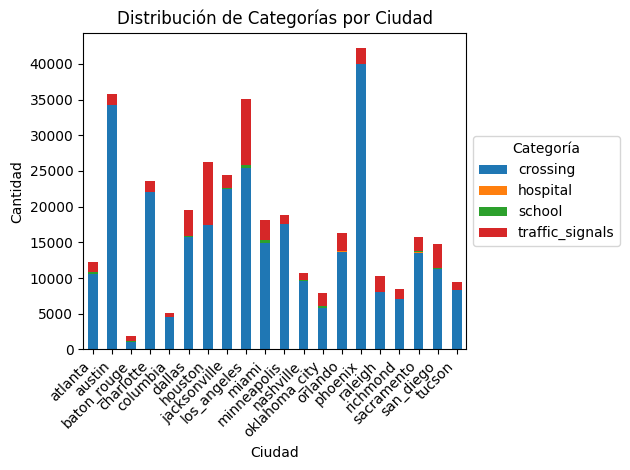

In [23]:
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar', stacked=True)
plt.title('Distribución de Categorías por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Categoría', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

### Conteo de Señales de Tráfico y Cruces por Ciudad

En esta sección se filtran las filas del DataFrame que corresponden a las categorías **`traffic_signals`** y **`crossing`**. Luego, se agrupan por ciudad para obtener el número total de señales y cruces en cada una. Esto permite analizar la distribución de elementos clave de infraestructura vial en las diferentes ciudades.


In [ ]:
traffic_crossing_counts = df[df['category'].isin(['traffic_signals', 'crossing'])].groupby('city').size()
print("Señales y cruces por ciudad:\n", traffic_crossing_counts)


Señales y cruces por ciudad:
 city
atlanta          11994
austin           35765
baton_rouge       1817
charlotte        23577
columbia          5145
dallas           19417
houston          26131
jacksonville     24374
los_angeles      34613
miami            17599
minneapolis      18767
nashville        10551
oklahoma_city     7792
orlando          16206
phoenix          42129
raleigh          10198
richmond          8445
sacramento       15459
san_diego        14623
tucson            9403
dtype: int64


### Visualización de Señales de Tráfico y Cruces por Ciudad

Se genera un gráfico de barras para representar visualmente la cantidad de **señales de tráfico** y **cruces** en cada ciudad.  
Esto ayuda a comparar rápidamente la densidad de estos elementos de infraestructura vial entre las distintas ubicaciones, facilitando la identificación de ciudades con mayor o menor número de estos elementos.


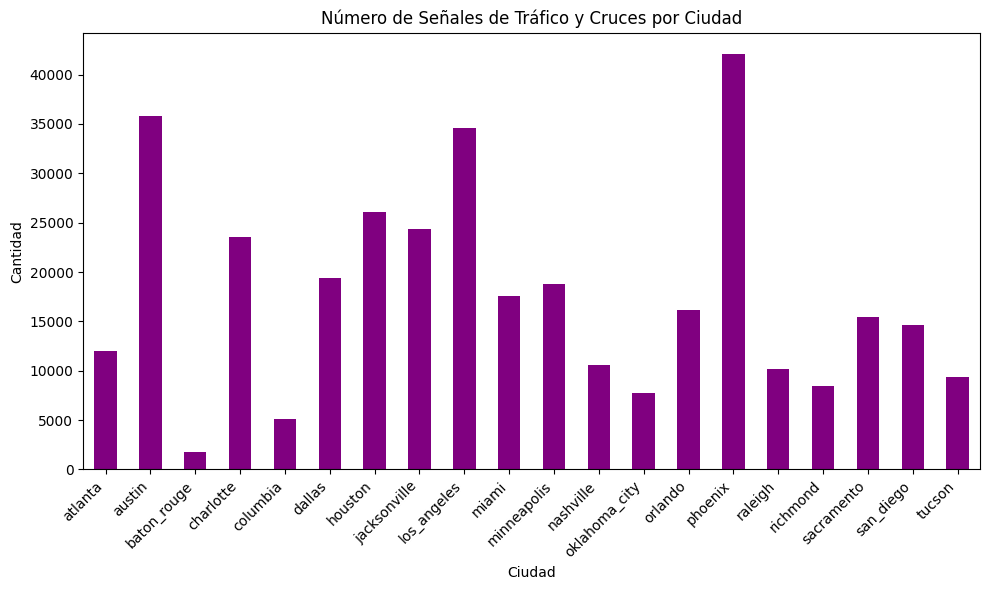

In [ ]:
plt.figure(figsize=(10, 6))
traffic_crossing_counts.plot(kind='bar', color='purple')
plt.title('Número de Señales de Tráfico y Cruces por Ciudad')
plt.xlabel('Ciudad')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Esta celda realiza una extracción y análisis de dos atributos clave desde la columna `tags`, la cual contiene información adicional en formato de diccionario para cada punto georreferenciado:

- **`traffic_signal_type`**: se extrae el tipo de señal de tráfico presente en el diccionario `tags`. Si no existe, se asigna `"unknown"`.
- **`crossing_type`**: se extrae el tipo de cruce peatonal usando la misma lógica.

Luego, se filtran los datos por las categorías `traffic_signals` y `crossing`, y se cuentan las ocurrencias de cada tipo para cada categoría. El resultado es un resumen impreso que muestra:

- La distribución de tipos de señales de tráfico presentes en el dataset.
- La distribución de tipos de cruces peatonales.

Esta información permite entender la diversidad de infraestructura vial que hay en los datos cargados desde OSM y es útil para futuros análisis comparativos entre ciudades o para priorizar intervenciones urbanas.

In [26]:
# Extraer información de tags
df['traffic_signal_type'] = df['tags'].apply(lambda x: x.get('traffic_signals', 'unknown'))
df['crossing_type'] = df['tags'].apply(lambda x: x.get('crossing', 'unknown'))

# Distribución de tipos de señales de tráfico
traffic_signal_counts = df[df['category'] == 'traffic_signals']['traffic_signal_type'].value_counts()
print("Tipos de señales de tráfico:\n", traffic_signal_counts)

# Distribución de tipos de cruces
crossing_counts = df[df['category'] == 'crossing']['crossing_type'].value_counts()
print("Tipos de cruces:\n", crossing_counts)

Tipos de señales de tráfico:
 traffic_signal_type
unknown                       31317
signal                         9273
traffic_lights                 9157
ramp_meter                      273
pedestrian_crossing             266
emergency                        79
blinker                          57
level_crossing                   11
crossing                          6
bus_priority                      6
blink_mode                        4
bridge                            3
traffic_lights;signal             2
blinkers                          2
stop                              2
traffic_lights3                   2
emergency_signal                  2
backward                          1
continuous_green                  1
forward                           1
pedestrian_crossing;signal        1
hawk                              1
Name: count, dtype: int64
Tipos de cruces:
 crossing_type
unmarked                         94873
unknown                          78661
traffic_signals       

# Visualización
Este tipo de visualización permite identificar rápidamente cuáles tipos de cruces son más comunes en los datos geoespaciales recolectados de OpenStreetMap.

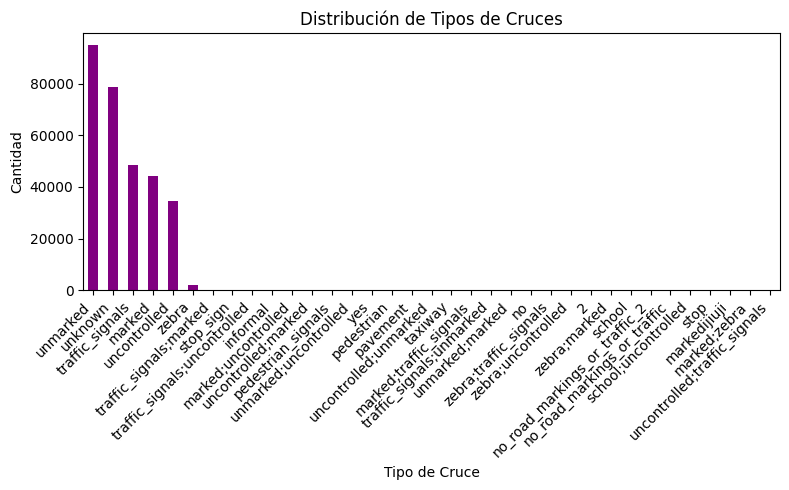

In [ ]:
plt.figure(figsize=(8, 5))
crossing_counts .plot(kind='bar', color='purple')
plt.title('Distribución de Tipos de Cruces')
plt.xlabel('Tipo de Cruce')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualización
Este tipo de visualización permite identificar rápidamente cuáles tipos de señales son más comunes en los datos geoespaciales recolectados de OpenStreetMap.

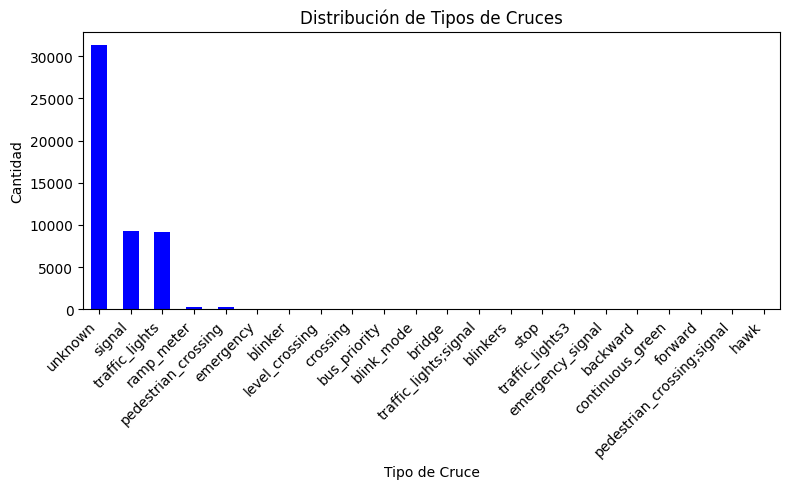

In [ ]:
plt.figure(figsize=(8, 5))
traffic_signal_counts.plot(kind='bar', color='blue')
plt.title('Distribución de Tipos de Cruces')
plt.xlabel('Tipo de Cruce')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Mapa de calor por categoría 
Se crea un GeoDataFrame con geopandas usando las coordenadas de latitud/longitud.

Luego se genera un mapa de calor con sns.kdeplot, mostrando la densidad de objetos por categoría (school, hospital, traffic_signals, crossing).

Este gráfico ayuda a identificar zonas de alta concentración de estos elementos.



C:\Users\Acer\AppData\Local\Temp\ipykernel_27652\3976951434.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


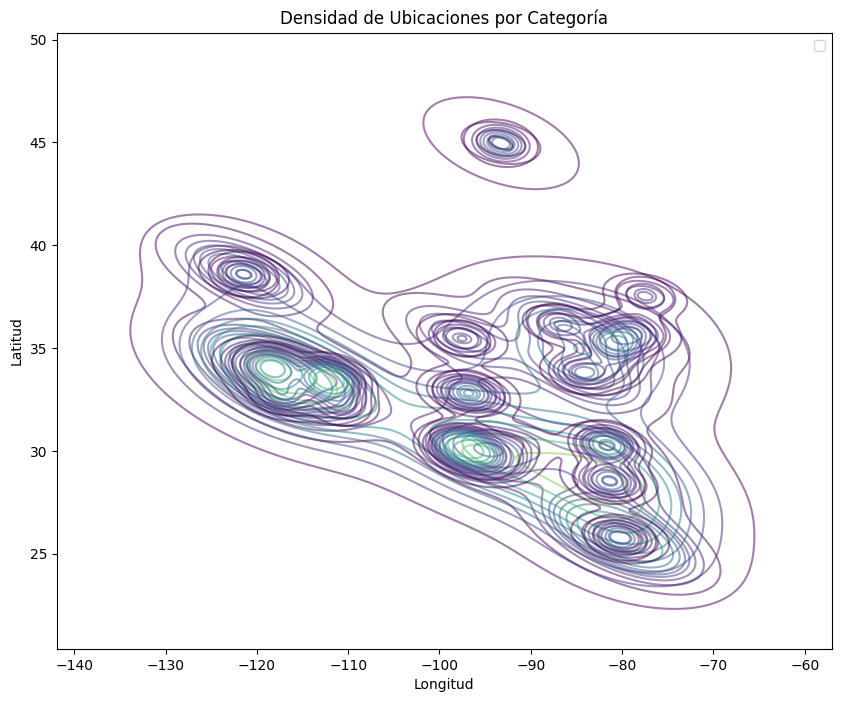

In [43]:
# Crear un GeoDataFrame
geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

# Mapa de calor por categoría
plt.figure(figsize=(10, 8))
for category, color in zip(['school', 'hospital', 'traffic_signals', 'crossing'], ['blue', 'red', 'green', 'purple']):
    subset = gdf[gdf['category'] == category]
    sns.kdeplot(data=subset, x='longitude', y='latitude', cmap='viridis', alpha=0.5, label=category)

plt.title('Densidad de Ubicaciones por Categoría')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.legend()
plt.show()

 ## Proximidad de escuelas y hospitales a señales de tráfico o cruces 
Se calcula la distancia más corta entre escuelas/hospitales y señales/cruces usando un árbol KD (cKDTree).

Se determina si están a menos de ~1 km.

Se añade una columna booleana has_nearby_traffic para indicar cercanía.

Luego se imprime la proporción de escuelas/hospitales con alguna señal/cruce cercano.

In [44]:
# Filtrar escuelas/hospitales y señales/cruces
schools_hospitals = gdf[gdf['category'].isin(['school', 'hospital'])]
traffic_crossings = gdf[gdf['category'].isin(['traffic_signals', 'crossing'])]

# Función para encontrar puntos cercanos
def find_nearest(gdf1, gdf2, max_distance=0.01):  # Aproximadamente 1 km
    coords1 = np.array(list(gdf1.geometry.apply(lambda x: (x.x, x.y))))
    coords2 = np.array(list(gdf2.geometry.apply(lambda x: (x.x, x.y))))
    tree = cKDTree(coords2)
    distances, indices = tree.query(coords1, k=1, distance_upper_bound=max_distance)
    return distances, indices

distances, indices = find_nearest(schools_hospitals, traffic_crossings)
schools_hospitals['nearest_traffic_distance'] = distances
schools_hospitals['has_nearby_traffic'] = distances < np.inf

# Resumen
print("Proporción de escuelas/hospitales con señales/cruces cercanos:\n",
      schools_hospitals.groupby('category')['has_nearby_traffic'].mean())

Proporción de escuelas/hospitales con señales/cruces cercanos:
 category
hospital    0.992481
school      0.976249
Name: has_nearby_traffic, dtype: float64


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


## Gráfico de cercanía a señales/cruces 
Gráfico de barras que muestra la proporción de escuelas y hospitales con señales o cruces cercanos.

Útil para visualizar la cobertura de seguridad vial alrededor de infraestructuras sensibles.



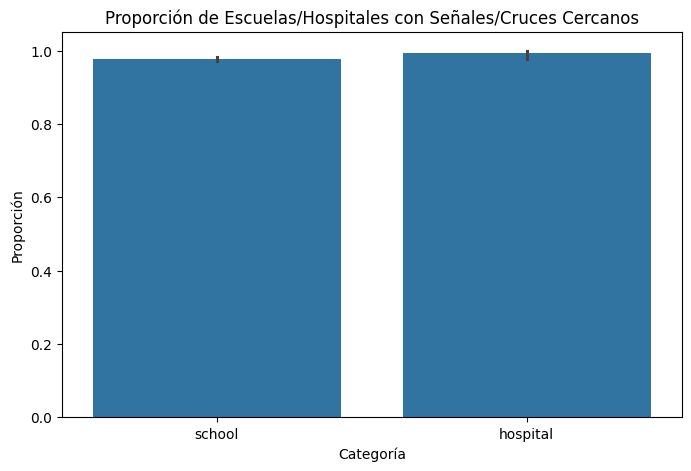

In [42]:
# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x='category', y='has_nearby_traffic', data=schools_hospitals)
plt.title('Proporción de Escuelas/Hospitales con Señales/Cruces Cercanos')
plt.xlabel('Categoría')
plt.ylabel('Proporción')
plt.show()

 ## Análisis de tipos de cruces


Se extrae el tipo de cruce desde el campo tags['crossing'] y se agrupa por ciudad.



In [ ]:
df['crossing_type'] = df['tags'].apply(lambda x: x.get('crossing', 'unknown'))

crossing_df = df[df['category'] == 'crossing']

crossing_type_by_city = crossing_df.groupby(['city', 'crossing_type']).size().unstack(fill_value=0)
print("Tipos de cruces por ciudad:\n", crossing_type_by_city)


Tipos de cruces por ciudad:
 crossing_type  2  informal  marked  marked;traffic_signals  \
city                                                         
atlanta        0         3    3429                       0   
austin         0         6    1694                       0   
baton_rouge    0         0     140                       0   
charlotte      2         0    1693                       0   
columbia       0         0    1810                       0   
dallas         0         3    1319                       0   
houston        0         3    1413                       0   
jacksonville   0         0    6720                       0   
los_angeles    0         8    3825                       0   
miami          0         1    2396                       0   
minneapolis    0         2    1616                       4   
nashville      0         0    1766                       0   
oklahoma_city  0         3     434                       0   
orlando        0         0    1768       

Se genera un gráfico de barras apiladas mostrando la distribución de tipos de cruce por ciudad.

Permite observar diferencias entre ciudades en cuanto a infraestructura peatonal.



<Figure size 1400x800 with 0 Axes>

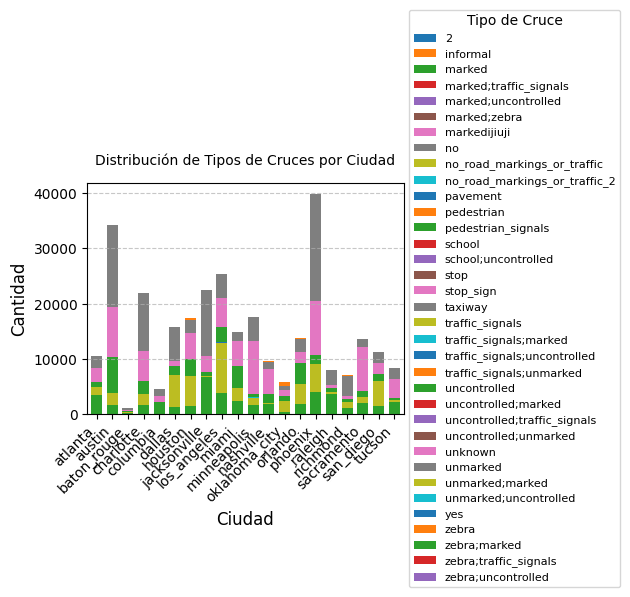

In [ ]:
plt.figure(figsize=(14, 8))
crossing_type_by_city.plot(kind='bar', stacked=True, width=0.7)
plt.title('Distribución de Tipos de Cruces por Ciudad', fontsize=10, pad=13)
plt.xlabel('Ciudad', fontsize=12)
plt.ylabel('Cantidad', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.legend(title='Tipo de Cruce', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8, title_fontsize=10)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

## Tipo de cruce más cercano a escuelas y hospitales
Para cada escuela u hospital, se identifica si el punto más cercano es un cruce y se extrae el tipo (tags['crossing']).

Se agrupa por categoría y tipo de cruce para ver la frecuencia de tipos cercanos.

In [115]:
# Identificar tipo de cruce más cercano
schools_hospitals['nearest_crossing_type'] = 'none'
for i, idx in enumerate(indices):
    if idx < len(traffic_crossings):
        nearest = traffic_crossings.iloc[idx]
        if nearest['category'] == 'crossing':
            schools_hospitals.iloc[i, schools_hospitals.columns.get_loc('nearest_crossing_type')] = nearest['tags'].get('crossing', 'unknown')

# Resumen
print("Tipos de cruces cercanos a escuelas/hospitales:\n",
      schools_hospitals.groupby(['category', 'nearest_crossing_type']).size())

Tipos de cruces cercanos a escuelas/hospitales:
 category  nearest_crossing_type 
hospital  marked                     22
          none                       37
          traffic_signals            14
          uncontrolled               20
          unknown                    26
          unmarked                   14
school    marked                    288
          none                      845
          traffic_signals           214
          traffic_signals;marked      1
          uncontrolled              364
          unknown                   489
          unmarked                  206
          zebra                      35
dtype: int64


## Gráfico de tipos de cruces cercanos 
Gráfico de barras agrupadas por category y coloreadas por nearest_crossing_type.

Muestra qué tan comunes son ciertos tipos de cruce alrededor de escuelas y hospitales.

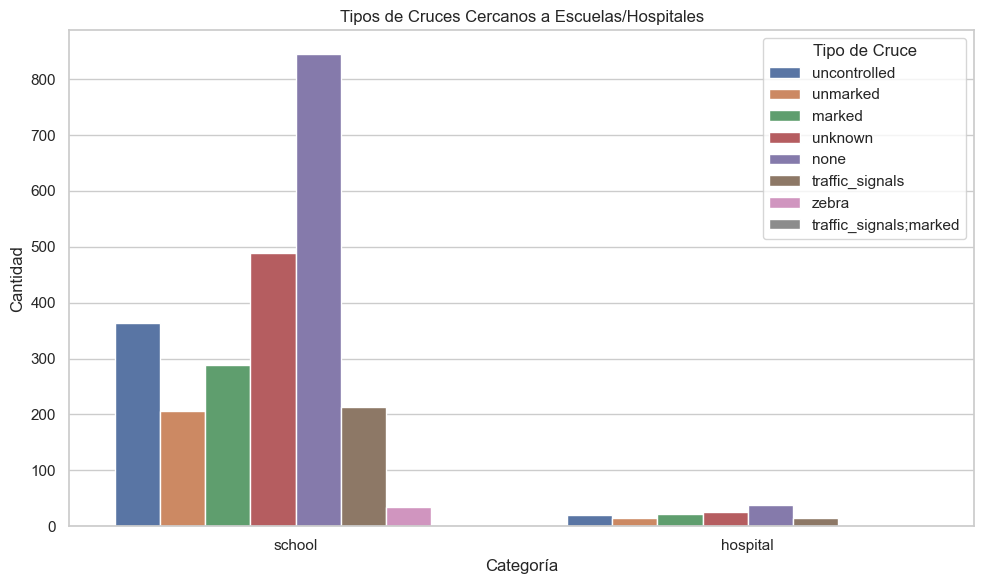

In [116]:
# Visualización
plt.figure(figsize=(10, 6))
sns.countplot(data=schools_hospitals, x='category', hue='nearest_crossing_type')
plt.title('Tipos de Cruces Cercanos a Escuelas/Hospitales')
plt.xlabel('Categoría')
plt.ylabel('Cantidad')
plt.legend(title='Tipo de Cruce')
plt.tight_layout()
plt.show()

## 🧾 Resumen estadístico (df_summary)
Se genera un resumen estadístico de los datos incluyendo media, mediana, desviación estándar, valores mínimos y máximos, para obtener una visión general de las variables cuantitativas y categóricas.

Se carga un CSV con datos de resumen (summary_osm_data.csv) 

In [5]:
df_summary = pd.read_csv('C:/Users/Acer/OneDrive/Escritorio/apis_proyecto/datos/summary_osm_data.csv')
df_summary.head() 

,city,group,value,count
0,atlanta,category,school,191
1,atlanta,category,hospital,7
2,atlanta,traffic_signals,unknown,968
3,atlanta,traffic_signals,signal,412
4,atlanta,traffic_signals,traffic_lights,6


## Y se inspecciona estructura, tipos y nulos.

In [6]:
df_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   city    254 non-null    object
 1   group   254 non-null    object
 2   value   254 non-null    object
 3   count   254 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 8.1+ KB


In [7]:
# Revisión de valores nulos
df_summary.isnull().sum()


city     0
group    0
value    0
count    0
dtype: int64

In [8]:
df_summary.dtypes


city     object
group    object
value    object
count     int64
dtype: object

 ## Visualización de accidentes por ciudad y grupo 
Gráfico de barras mostrando accidentes segmentados por city y group.

Permite observar patrones de accidentes según el grupo (por ejemplo, categoría o tipo de incidente).



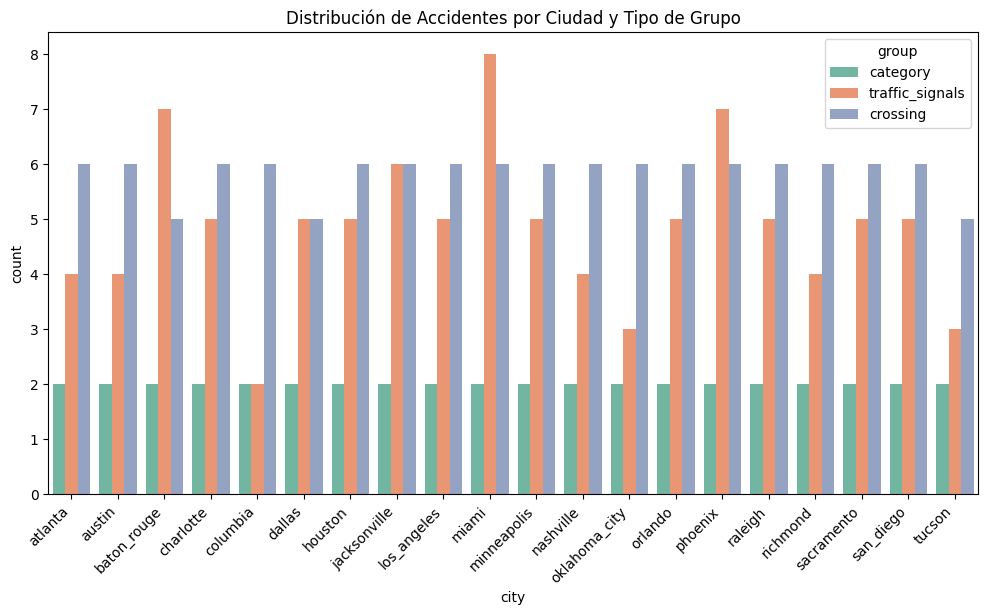

In [9]:
# Ver distribución de accidentes por 'city' y 'group'
plt.figure(figsize=(12, 6))
sns.countplot(data=df_summary, x="city", hue="group", palette="Set2")
plt.xticks(rotation=45, ha="right")  # Ajustar los labels en el eje X para mayor legibilidad
plt.title("Distribución de Accidentes por Ciudad y Tipo de Grupo")
plt.show()


## Hospitales y escuelas por ciudad
Se pivotea df_summary para obtener un DataFrame con columnas school y hospital por ciudad.

Luego se genera un gráfico de barras apiladas mostrando cantidad de escuelas y hospitales por ciudad.

C:\Users\Acer\AppData\Local\Temp\ipykernel_27652\3297864788.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


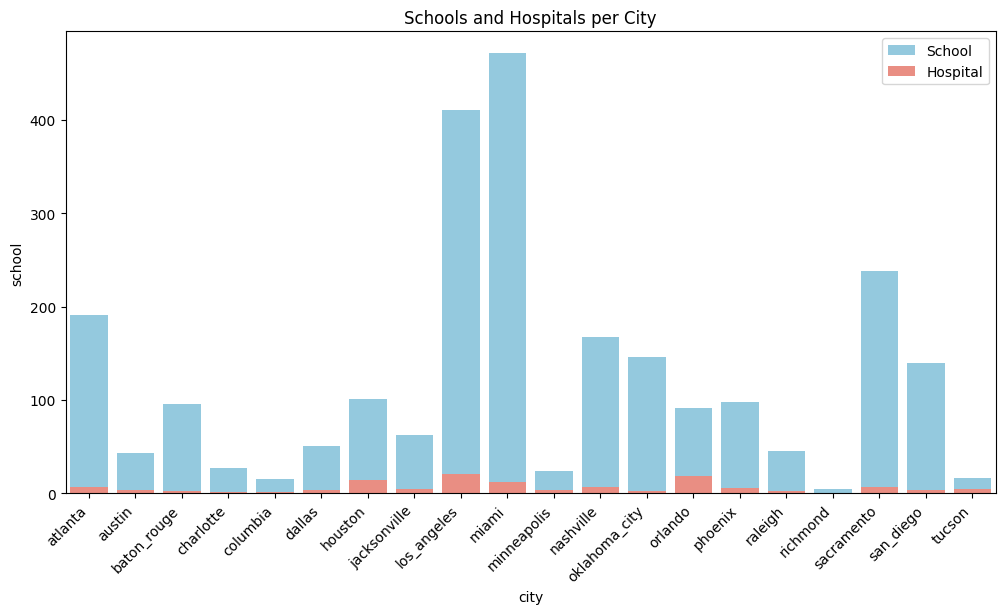

In [11]:
# Pivot the DataFrame to have school and hospital as columns
df_pivoted = df_summary[df_summary['group'] == 'category'].pivot_table(
    index='city', 
    columns='value', 
    values='count', 
    fill_value=0
).reset_index()

# Create the bar plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_pivoted, x='city', y='school', color='skyblue', label='School')
sns.barplot(data=df_pivoted, x='city', y='hospital', color='salmon', label='Hospital', ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_title('Schools and Hospitals per City')
plt.legend()
plt.show()

## Hallazgos clave
Variabilidad urbana: Las ciudades no tienen una distribución homogénea de infraestructura crítica y vial.

Cobertura vial razonable: En general, las escuelas y hospitales están razonablemente cubiertos por señales o cruces, aunque hay excepciones.

Diferencias en diseño urbano: Hay diversidad en tipos de cruce entre ciudades, lo cual puede influir en decisiones de movilidad urbana o seguridad vial.

